In [2]:
from astropy.cosmology import FlatwCDM
import wcosmo
import numpy as np
import matplotlib.pyplot as plt

In [3]:
Clight = 3e8
z_arr = np.linspace(0.0001,5,num=100)
H0_vals = [50,70,90]
Om_vals = [0.1,0.3,0.5,0.9]
colors = ['blue','orange','purple',"green"]
w_vals = [-2,-1,0,1]

In [28]:
def absolute_comparison(func, H0_arr=H0_vals, Om_arr=Om_vals, w=-1, colors=colors, linestyles=["--","solid"], z_arr=z_arr, custom=None):
    """custom must be a list of the form [label,arr] where label is a string and arr is an array-like object with same length of z_arr, for plotting"""
    fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
    for H0, c in zip(H0_arr,colors):
        axes[0].plot(z_arr,wcosmo.FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr),ls=linestyles[0],lw=3,c=c)
        axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr), color=c,ls=linestyles[1],label=f"$H_0=${H0} km/s/kpc")
        if custom is not None:
            axes[0].plot(z_arr,custom[1],ls=linestyles[2],lw=3,c=c)
    axes[0].plot([],c='k',ls=linestyles[1],label="astropy")
    axes[0].plot([],c='k',ls=linestyles[0],lw=3,label="approximant")
    if custom is not None:
        axes[0].plot([],c='k',ls=linestyles[2],lw=3,label=custom[0])
    axes[0].legend(ncol=2)

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
    for Om, c in zip(Om_arr,colors):
        axes[1].plot(z_arr,wcosmo.FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr),ls=linestyles[0],lw=3,c=c)
        axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr),color=c,ls=linestyles[1],label=f"$\Omega_m=${Om}")
    axes[1].plot([],c='k',ls=linestyles[1],label="astropy")
    axes[1].plot([],c='k',ls=linestyles[0],lw=3,label="approximant")
    if custom is not None:
        axes[1].plot([],c='k',ls=linestyles[2],lw=3,label=custom[0])
    axes[1].legend(ncol=2)

    for i in [0,1]:
        axes[i].set_xlabel("z")
    return fig


def fractional_comparison(func, H0_arr=H0_vals, Om_arr=Om_vals, w=-1, colors=colors, z_arr=z_arr):
    """custom must be a list of the form [label,arr] where label is a string and arr is an array-like object with same length of z_arr, for plotting"""
    fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=False,figsize=(10,5))
    # axis 0: vary H0
    axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
    for H0, c in zip(H0_arr,colors):
        ap = FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr).value
        fracerr = (wcosmo.FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr)-ap)/ap
        axes[0].plot(z_arr,fracerr, c=c,label=f"$H_0=${H0} km/s/kpc")
    axes[0].legend(ncol=2)

    # axis 1: vary Om0
    axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
    for Om, c in zip(Om_arr,colors):
        ap = FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr).value
        fracerr = (wcosmo.FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr)-ap)/ap
        axes[1].plot(z_arr,fracerr, c=c,label=f"$\Omega_m=${Om}")
    axes[1].set_yscale("log")
    for i in [0,1]:
        axes[i].set_xlabel("z")
    return fig

## $w=-1$
The original approximant in Adachi & Kasai 2011 look very accurate when $\Omega_m \gtrsim 0.1$, so priors on $\Omega_m$ should exclude $\leq 0.1$ when using that approximant. When using the `wcosmo` approximant (which includes more terms), $\Omega_m \lesssim 0.1$ seems to look good!

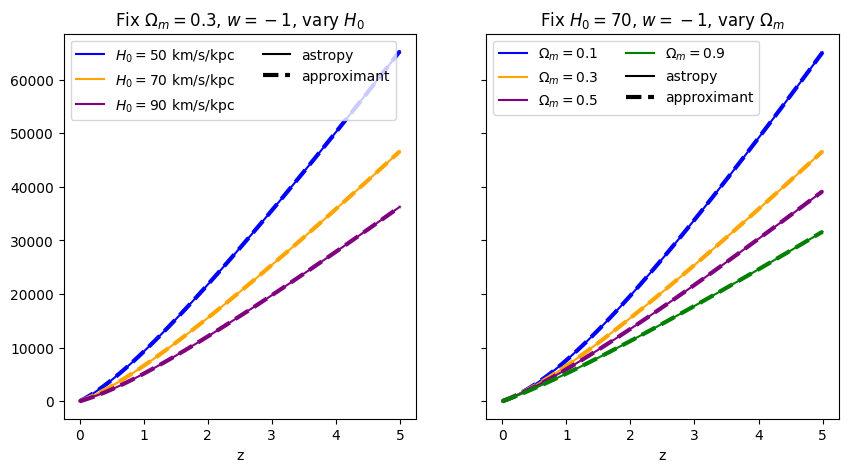

In [25]:
# luminosity distance
absolute_comparison("luminosity_distance");

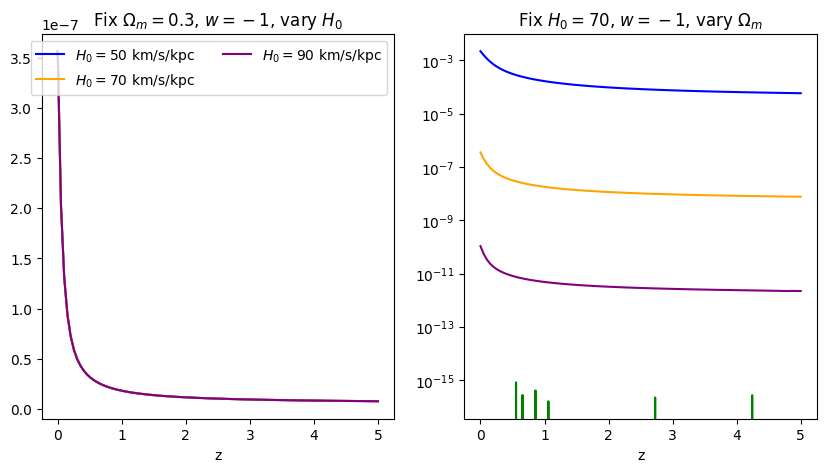

In [26]:
fractional_comparison("luminosity_distance");

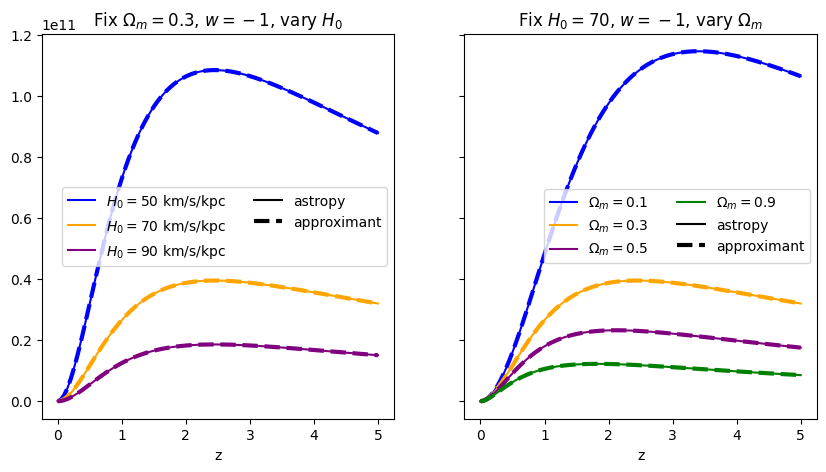

In [ ]:
# differential comoving volume
absolute_comparison("differential_comoving_volume");

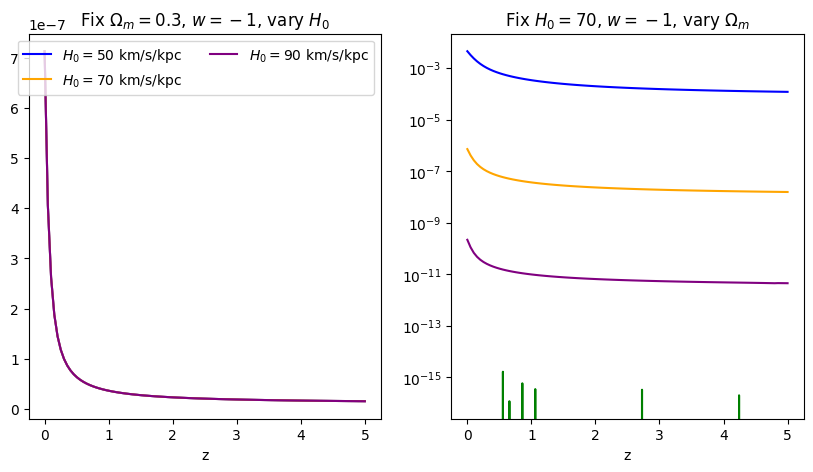

In [17]:
# fractional error in diff comov. vol
fractional_comparison("differential_comoving_volume");

Text(0, 0.5, '$\\frac{dD_L}{dz} [Mpc]$')

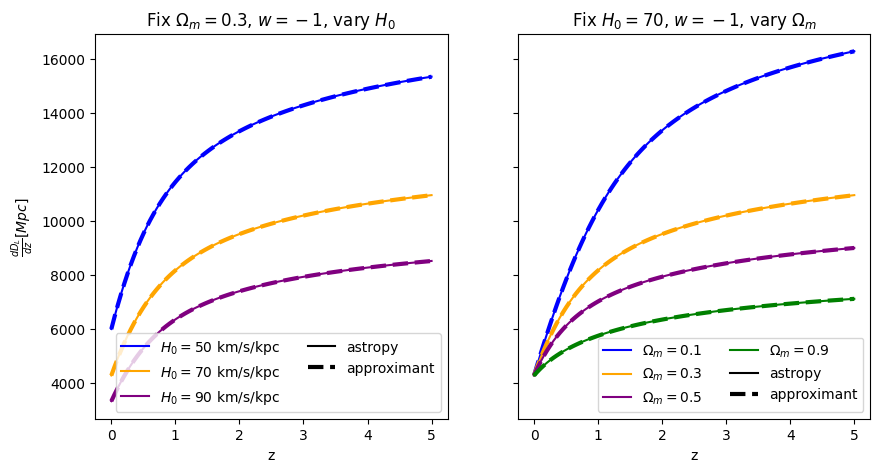

In [7]:
# Jacobian factor: ddL/dz

def dDL_dz(astropycosmo,z):
    dL = astropycosmo.luminosity_distance(z).value
    Ez_i = astropycosmo.inv_efunc(z)
    D_H = (Clight/1e3) / astropycosmo.H0.value
    return np.abs(dL/(1.+z) + (1.+z)*D_H * Ez_i)

fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,wcosmo.FlatLambdaCDM(H0=H0,Om0=0.3).dDLdz(z_arr),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,dDL_dz(FlatwCDM(H0=H0,Om0=0.3),z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,wcosmo.FlatLambdaCDM(H0=70,Om0=Om).dDLdz(z_arr),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,dDL_dz(FlatwCDM(H0=70,Om0=Om),z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

for i in [0,1]:
    axes[i].set_xlabel("z")
axes[0].set_ylabel("$\\frac{dD_L}{dz} [Mpc]$")

## Adapted with $w\neq-1$

The new taylor expansion is:
\begin{equation}
F = \sqrt{a} \sum_{n=0}^{\infty}{-1/2 \choose n} \frac{x^n}{1/2-3wn}
\end{equation}

In [31]:
def Phi_w(x,w=-5):
    num = 2 * (64 + 80*x + 24*x**2 + x**3 - 24 * w * (624 + 760 * x + 222*x**2 + 9*x**3) + 
    144 * w**2 * (11920 + 14560 * x + 4278*x**2 + 175*x**3) - 
    1728 * w**3 * (71672 + 87840 * x + 25791*x**2 + 1049*x**3) + 
    2592 * w**4 * (2356832 + 2882800 * x + 839268*x**2 + 33719*x**3) - 
    62208 * w**5 * (3445928 + 4201240 * x + 1212453*x**2 + 48254*x**3) + 
    313456656384 * w**12 * (3319040 + 4519200 * x + 1598688*x**2 + 
       111783*x**3) + 
    186624 * w**6 * (29448112 + 35918800 * x + 10359714*x**2 + 413179*x**3) - 
    17414258688 * w**11 * (30788544 + 38850120 * x + 11816424*x**2 + 
       495569*x**3) - 
    2239488 * w**7 * (46909544 + 57549840 * x + 16745037*x**2 + 668609*x**3) + 
    1934917632 * w**10 * (61958336 + 76676430 * x + 22483512*x**2 + 
       837203*x**3) - 
    120932352 * w**9 * (133531520 + 165267720 * x + 48520736*x**2 + 
       1828153*x**3) + 
    1679616 * w**8 * (900485632 + 1112477520 * x + 326613696*x**2 + 
       12787417*x**3))
    den = (-1 + 6 * w) * (-1 + 12 * w) * (-1 + 18 * w) * (64 + 112 * x + 56 * x**2 + 7 * x**3 - 
   12*w * (1056 + 1792 * x + 868 * x**2 + 105 * x**3) + 
   36*w**2 * (34304 + 58128 * x + 28336 * x**2 + 3479 * x**3) - 
   432*w**3 * (171968 + 288960 * x + 139552 * x**2 + 16891 * x**3) - 
   241864704*w**9 * (3319040 + 4519200 * x + 1598688 * x**2 + 111783 * x**3) + 
   1296*w**4 * (2260032 + 3729936 * x + 1763944 * x**2 + 209097 * x**3) - 
   3919104*w**7 * (4782720 + 7538144 * x + 3394704 * x**2 + 391167 * x**3) - 
   15552*w**5 * (5009056 + 8107680 * x + 3754156 * x**2 + 439439 * x**3) + 
   6718464*w**8 * (25067648 + 37946160 * x + 15870960 * x**2 + 1547889 * x**3) + 
   46656*w**6 * (30759808 + 49091504 * x + 22480304 * x**2 + 2667861 * x**3))
    return -1*num/den

def xx_w(z,Om0,w=-5):
    return (1.0-Om0)/Om0/np.power(1.0+z,-3*w)

def dL_approx_w(z,H0,Om0,w):
    D_H = (Clight/1.0e3)  / H0 #Mpc
    return D_H * (1.+z) * (Phi_w(xx_w(0.,Om0,w),w) - Phi_w(xx_w(z,Om0,w),w)/np.sqrt(1.+z))/np.sqrt(Om0)


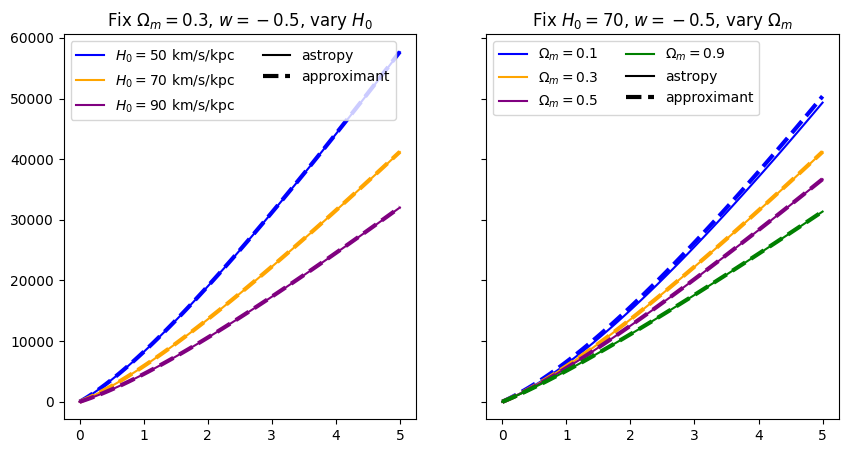

In [32]:
fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
w = -0.5
axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,dL_approx_w(z_arr,H0,0.3,w=w),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3,w0=w).luminosity_distance(z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,dL_approx_w(z_arr,70,Om,w=w),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om,w0=w).luminosity_distance(z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

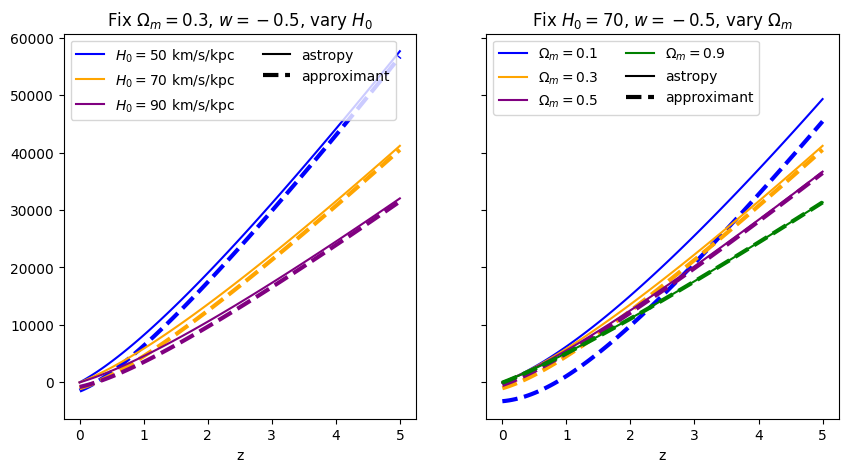

In [34]:
absolute_comparison("luminosity_distance",w=-0.5);

2.64086441484343